In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots are configured to be rendered as images because otherwise they won't display correctly on GitHub or when the notebook is loaded (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.


# Welcome to __Timeseria__! #

Timeseria is an object-oriented time series processing library which aims at making it easy to manipulate time series data and to build statistical and machine learning models on top of it.

It comes with a built-in set of common operations (resampling, aggregation, differencing etc.) and models (reconstruction, forecasting and anomaly detection) which can cover a variety of simple use-cases. Moreover, both custom operations and models can be easily plugged in.

Timeseria also addresses by design all those annoying things which are often left as an implementation detail but that actually cause wasting massive amounts of time - as handling data losses, non-uniform sampling rates, differences between time-slotted (aggregated) data and punctual observations, variable time units, timezones, DST changes and so on.

This is a realitively structured welcome tutorial. If you are looking o get started immeditaley, have a look at the [quickstart notebook](https://github.com/sarusso/Timeseria-notebooks/blob/master/notebooks/Quickstart.ipynb). Also the [reference documentation](https://timeseria.readthedocs.io) might be useful.

### Table of contents


* [**Data Structures**](#data_structures)
    * [Points](#points)
    * [Slots](#slots)
    * [Series](#time_series)
* [**Transformations**](#transformations)
    * [Resampling](#resampler)
    * [Aggregations](#slotter)
* [**Operations**](#operations)
* [**Models**](#models)
    * [Reconstructors](#reconstructors)
    * [Forecasters](#forecasters)
    * [Anomaly detectors](#anomaly)
    * [Custom models](#custom)
    * [Model evaluation](#evaluation)
* [**Timezones and their implications**](#timezones)
* [**Where to go from here**](#where_to_go)



# Base Data structures <a class="anchor" id="data_structures"></a>

## Points <a class="anchor" id="points"></a>
***
__*Points*__ are the most basic datastructure. They can be initialized in any n-dimensional space you want:

In [2]:
from timeseria.datastructures import Point
point = Point(5,7)

..that's it, just a point:

In [3]:
point

Point @ (5,7)

__*TimePoints*__ are Points in the "time" dimension, which is epoch (the number of seconds from the midnight of 1st January 1970, UTC). Milliseconds, microseconds etc. can be expressed using the decimal places.

In [4]:
from timeseria.datastructures import TimePoint
TimePoint(60.857754)

Time point @ 60.857754 (1970-01-01 00:01:00.857754+00:00)

They put some more focus on time management, and for added clarity and ease of use their time coordinate can be also set and accessed as "t" as well as "dt" using Python DateTime objects:

In [5]:
timepoint = TimePoint(t=60)
timepoint.t

60

In [6]:
from propertime.utils import dt
timepoint = TimePoint(dt=dt(1970, 1, 1, 0, 1))
timepoint.dt

datetime.datetime(1970, 1, 1, 0, 1, tzinfo=<UTC>)

..and you can of course set the "t" and access the "dt" and vice-versa, they get automatically computed. Aslo note that when setting the dt here above, the UTC timezone has been automatically set as in Timeseria no timestamps without timezones are allowed.

In [7]:
timepoint.t

60.0

__*DataTimePoints*__ are TimePoints with some data attached. This data can be whatever you want: a string, an image, a single value, a list of values, a dict of values. However, most of the functionalities of Timeseria require it to be in the form of a list of numerical values or a dict of numerical values, which is the format that will be used in the following.

In [8]:
from timeseria.datastructures import DataTimePoint
DataTimePoint(t=60.857754, data=[56.8])

Time point @ 60.857754 (1970-01-01 00:01:00.857754+00:00) with data "[56.8]"

This concept, of encapsulating data on another level with respect to the time coordinate, it is one of the main building pillars of Timeseria. Timeseria does not indeed represent time series using matrices of x,y data where x is the time and y is the value. Instead, it attach to a point in time its data, in a nested way.

Data can be virtually of any kind, but to use all of the built-in operations, indexed or key-value formats are required. In the above example data is in list format, while the following one uses instead a dictionary: 

In [9]:
DataTimePoint(t=60.857754, data={'temperature':56.8})

Time point @ 60.857754 (1970-01-01 00:01:00.857754+00:00) with data "{'temperature': 56.8}"

In both cases the `data_labels()` method allows to get the labels of the data. If data is in key-value format as a dictionary, then these are the dictionary keys, if data is an indexed format as a list, then labels are generated from the list indexes (as string).

In [10]:
DataTimePoint(t=60.857754, data={'temperature':56.8}).data_labels()

['temperature']

__*DataTimePoints*__ can also have a specific attribute for handlig missing data, the *data_loss* index (a floating point number between 0 and 1), that is automatically computed when resampling or aggregating:

In [11]:
DataTimePoint(t=60.857754, data={'temperature':56.8}, data_loss=0.76)

Time point @ 60.857754 (1970-01-01 00:01:00.857754+00:00) with data "{'temperature': 56.8}" and data_loss="0.76"

The data_loss index is a special case of a more generic concept: the *data indexes*. These are indicators in a 0-1 range of some property of the data, for example if it got reconstructed and by how much, or if it is anomalous (following an anomaly detection model run).

In [12]:
point = DataTimePoint(t=60.857754, data={'temperature':56.8}, data_indexes={'data_loss':0.76, 'anomaly':1})

The data_loss can be set in both methods. After being set, the data indexes can be accessed using the `data_indexes` attribute:

In [13]:
point.data_indexes

{'data_loss': 0.76, 'anomaly': 1}


## Slots <a class="anchor" id="slots"></a>
***

While points are meant to represent punctual observations (i.e. a sensor reading or an event occured at a specific time), slots are meant to represent data over a time period (i.e. from a meter or aggregated over time). Before intorducing them, let's move a step back to explain while it is worth to add a different data structure other than the point.

In time series, samples are naturally identified with a specific point in time, in particular when the sampling rate is high (i.e. a data point every minute). However, when it comes to lowe sampling rates (i.e. a datapoint every hour) or to data aggregated over a time period, the punctual definition of the sample starts falling apart. 

When we talk about hourly data at 15:00, are we talking about a punctual observation for 15:00 (and therefoe somewhat representative of what happened between 14:30 to 15:30), or are we talking about the aggregated data between 15:00 and 16:00?

Things get ever worse when we talk about days, months and years: while hours and minute intervals have always the same length in seconds (60 and 3600, respectively), a day can last 23, 24 or 25 hours, due to daylight saving time. So that if you identify a day by its midnight, you can't just add 24 hours to get to the next day. Similary for months and years due to the variable number of days.

To properly address these issues, Timeseria formalizes and introduces a new concept alongside the Point: the ***Slot***.

A ***Slot***, unlike a Point, it is not identified by a single coordinate, but by a starting and and ending point:



In [14]:
from timeseria.datastructures import Slot
Slot(start=Point(1), end=Point(3))

Slot @ [1,3]

Which in two dimensions is a rectangle, and in one dimension (like in the time dimension) is basically just an interval.

As for the Points, we have also ***TimeSlots***, ***DataSlots*** and, most importantly, the ***DataTimeSlot***:

In [15]:
from timeseria.datastructures import DataSlot
DataSlot(start=Point(1), end=Point(2), data=[24.5])

Slot @ [1,2] with data "[24.5]"

In [16]:
from timeseria.datastructures import DataTimeSlot
DataTimeSlot(start=TimePoint(t=0), end=TimePoint(t=3600), data=[24.5])

Time slot @ [0,3600] ([1970-01-01 00:00:00+00:00,1970-01-01 01:00:00+00:00]) with data=[24.5]

Slots are naturally associated with a ***unit***, which represents the portion of the space occupied by the slot itself:

In [17]:
slot = Slot(start=Point(1), end=Point(3))
slot.unit

2

You can create slots by just setting the starting point and the unit, using the ***Unit*** object:

In [18]:
from timeseria.units import Unit
DataSlot(start=Point(1), unit=Unit(2), data=[24.5])

Slot @ [1,3] with data "[24.5]"

...and the ***TimeUnit*** object for units of time:

In [19]:
from timeseria.units import TimeUnit
DataTimeSlot(start=TimePoint(7200), unit=TimeUnit(3600), data=[24.5])

Time slot @ [7200,10800.0] ([1970-01-01 02:00:00+00:00,1970-01-01 03:00:00+00:00]) with data=[24.5]

The reason for a dedicated TimeUnit object is to support *variable* length time units, which might look like a counter-intuitive concept but it is on the contrary the only way to handle calendar times units as days, weeks, and years.

Indeed, while in the time dimension a slot with a length of 3600 is just an hour, an 86400-length slot is not a day! This is because days are actually a variable lenght unit, since due to Daylight Saving Time they can last 86400, 82800 or 90000 seconds. The same applies for months (which can have a variable number of days) and in turn, for years (with the leap years).

TimeUnits are defined either manually setting all their components (ad for Python datetime objets) or using their string representation: <code>1s</code> for one second, <code>1m</code> for one minute, <code>1h</code> for one hour, <code>1D</code> for one day, <code>1M</code> for one month, <code>1W</code> for one weelk and <code>1Y</code> for one year. The <code>1</code> can be replaced by any integer of choice.

For example, to create a one-day slot using a TimeUnit object:

In [20]:
from timeseria.units import TimeUnit
DataTimeSlot(start=TimePoint(dt=dt(1970,1,2,0,0,0)), unit=TimeUnit('1D'), data=[24.5])

Time slot @ [86400.0,172800.0] ([1970-01-02 00:00:00+00:00,1970-01-03 00:00:00+00:00]) with data=[24.5]

TimeSlots defined by a "calendar" **TimeUnit**, like "1D" for one day and "1M" for one month can therefore have _different_ lengths even if they represent slots with the same time unit.

TimeUnit objects are quite powerful and support string comparison and time math, so that you can manipluate them realively easily sum a day after another or a month after another. They can also be used for generic time manipulation with classic Python datetime objects. Here are some examples:

In [21]:
TimeUnit('1D') == '1D'

True

In [22]:
dt(1970, 1, 1, 0, 0) + (TimeUnit('1D') + TimeUnit('3D'))

datetime.datetime(1970, 1, 5, 0, 0, tzinfo=<UTC>)

However, be aware that some operations are are not always well-defined, for example if you sum a TimeUnit of one month to the 31st of January, you would end up on the 31st of February, which does not exist (and that will lead to an error).

In [23]:
try:
    dt(1970, 1, 31, 0, 0) + TimeUnit('1M')
except ValueError as e:
    print(e)

Day is out of range for month for 1970-01-31 00:00:00+00:00 plus 1 month(s)


As for the DataTimePoints, DataTimeSlots can also have a ***data_loss*** index, which represents how well the slot is "covered" by the underlying data points. If you for example have hourly slots computed out from 10-minute data points, and you miss two of them for a given slot, this slot will have a data_loss of 0.66. Data losses are usually automatically computed out from resampling or slotting transformations, but can also be set manually:

In [24]:
DataTimeSlot(start=TimePoint(t=0), end=TimePoint(t=3600), data=[5], data_loss=0.66)

Time slot @ [0,3600] ([1970-01-01 00:00:00+00:00,1970-01-01 01:00:00+00:00]) with data=[5] and data_loss=0.66

Other data indexes are supported as well, exactly as for the DataTimePoints:

In [25]:
slot = DataTimeSlot(start=TimePoint(t=0), end=TimePoint(t=3600), data=[5], data_indexes={'anomaly':1})

In [26]:
slot.data_indexes

{'anomaly': 1}


# Series <a class="anchor" id="time_series"></a>
***

Series are defined as a list of items coming one after another, where every item is guaranteed to be of the same type and in an order or succession.

For example, 1,2,3 are in order; 1,3,8 are in order; and 1,8,3 are of course not in order. However, 5,6,7 are in an integer succession, but 5,6,8 are not in an integer succession.

This difference is importnat when defining the type of the series: if it holds items that are in an order, there is no requirement of not having any "gap" (which my be aslo not defined as a concept), but if they are in succession, then the succession requirement is

To anticipate what's coming nexts, point series will require their points to be ordered, while slot series will require the slots to be in succession, and therefore do cover densely the time dimension, with no gaps.

In [27]:
from timeseria.datastructures import Series

series = Series(1,2,3)

In [28]:
series

Series of #3 elements

Series extend the built-in Python list class, but enforce the order (or the succession) of their items and require to have them all of the same kind: 

In [29]:
try:
    series = Series(1,3,2)
except Exception as e:
    print(e)

Not in order ("2" does not follow "3")


In [30]:
try:
    series = Series(1,2,3.0)
except Exception as e:
    print(e)

Got incompatible type "float", can only accept "int"


Time series are implemented using the   __*TimeSeries*__ object, which is a series of DataTimePoints or DataTimeSlots (or of TimePoints or TimeSlots in particular circumstances). Creating a time series using the __TimeSeries__ object is similar to creating Python list:

In [31]:
from timeseria.datastructures import TimeSeries

timeseries = TimeSeries(DataTimePoint(t=60, data=[5.8]),
                        DataTimePoint(t=120, data=[6.1]),
                        DataTimePoint(t=180, data=[5.7]),
                        DataTimePoint(t=240, data=[4.8]))

In [32]:
timeseries

Time series of #4 points at 1m resolution, from point @ 60 (1970-01-01 00:01:00+00:00) to point @ 240 (1970-01-01 00:04:00+00:00)

As for Python lists, you can also append new items:

In [33]:
timeseries.append(DataTimePoint(t=300, data=[5.1]))

Time series can be created in simpler ways than to explicitly instantiate the DataTimePoints, for example from dict or list data, from a Pandas dataframe, or drom a CSV file. Here are some examples:

In [34]:
TimeSeries.from_dict({60: 14.5,
                      120: 18.3,
                      180: 16.8})

Time series of #3 points at 1m resolution, from point @ 60 (1970-01-01 00:01:00+00:00) to point @ 180 (1970-01-01 00:03:00+00:00)

In [35]:
from timeseria import TEST_DATASETS_PATH

TimeSeries.from_csv(TEST_DATASETS_PATH + 'temp_short_10m.csv')

Time series of #100 points at 10m resolution, from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1546536600.0 (2019-01-03 17:30:00+00:00)

Time series can be easily plotted using their `plot()` method:

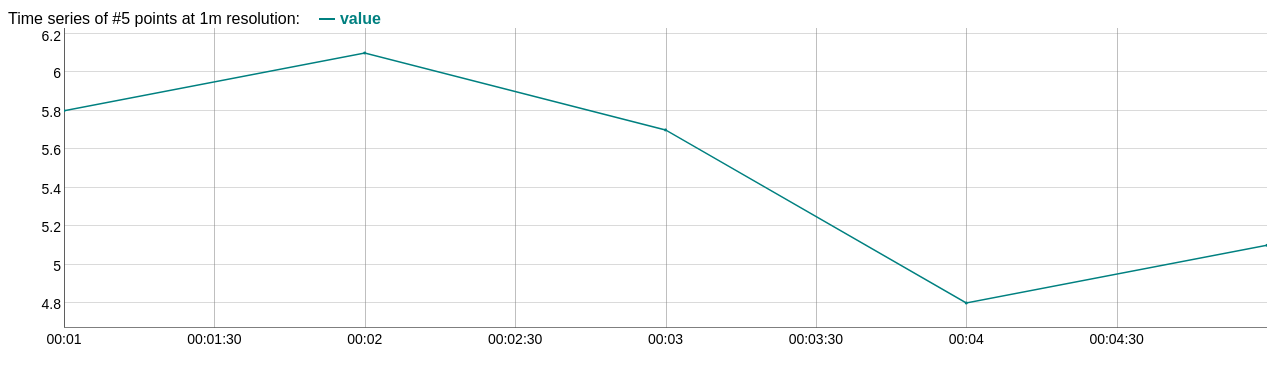

In [36]:
timeseries.plot()

By default, and unlsess otherwise set (as in this Notebook), the plot function generates an interactive plot. To get an image-based, non-interactive plot, just use `plot(image=True)`. In this case Timeseria will automatically download a headless Chromium engine, which is required for rendering plots as images.

Plotting in Timeseria is powered by Dygraphs, which is exclusively designed for time series data, and can smoothly handles thousands and even millions of data points, as when there is too much data Timeseria performs an aggegation before plotting them to prevent crashing the engine plotting engine (or your web browser). 

Time series have a *resolution* attribute which returns a TimeUnit object representing the temporal resolution of the time series, to be intended as sampling interval for point series or as the slot units for slot series:

In [37]:
timeseries.resolution

1m

In [38]:
type(timeseries.resolution)

timeseria.units.TimeUnit

There are two special cases in which the resolution attribute behaves differently:
        
* if the resolution is not defined (returns `None`), either because the time series is empty or because it has only one point; or
* the resolution is variable (returns the string `variable`), because the data points are not equally spaced, for example due to data losses or uneven observations.

For example, let's add a point to the previus time series, but out of the sequence (skipping two of them and Jumping directly to 420 seconds):

In [39]:
timeseries.append(DataTimePoint(t=420, data=[7.3]))

...and let's check again the resolution:

In [40]:
timeseries.resolution

'variable'

In this case, the `guess_resolution()` method might come handy, which guesses and returns the resolution (as a TimeUnit object):

In [41]:
timeseries.guess_resolution()

1m

You can also get the confidence of the estimate:

In [42]:
timeseries.guess_resolution(confidence=True)

{'value': 1m, 'confidence': 0.75}

Time series can be sliced and their items can be accessed in many ways, and in particular, besides as for classic Python lists, using special strings with `t` or `dt` keywords:

In [43]:
timeseries[1:2]

Time series of #1 points at undefined resolution, from point @ 120 (1970-01-01 00:02:00+00:00) to point @ 120 (1970-01-01 00:02:00+00:00)

In [44]:
timeseries[dt(1970,1,1,0,1,0)]

Time point @ 60 (1970-01-01 00:01:00+00:00) with data "[5.8]"

In [45]:
timeseries[120.0:300.0]

Time series of #3 points at 1m resolution, from point @ 120 (1970-01-01 00:02:00+00:00) to point @ 240 (1970-01-01 00:04:00+00:00)

Going back to the data structures, you can also create a slot timeseries:

In [46]:
timeseries = TimeSeries(DataTimeSlot(start=TimePoint(dt=dt(2016,1,1)), unit=TimeUnit('1M'), data={'kWh':5.8}),
                        DataTimeSlot(start=TimePoint(dt=dt(2016,2,1)), unit=TimeUnit('1M'), data={'kWh':6.1}),
                        DataTimeSlot(start=TimePoint(dt=dt(2016,3,1)), unit=TimeUnit('1M'), data={'kWh':5.7}),
                        DataTimeSlot(start=TimePoint(dt=dt(2016,4,1)), unit=TimeUnit('1M'), data={'kWh':4.8}))

In [47]:
timeseries

Time series of #4 slots of 1M, from slot starting @ 1451606400.0 (2016-01-01 00:00:00+00:00) to slot starting @ 1459468800.0 (2016-04-01 00:00:00+00:00)

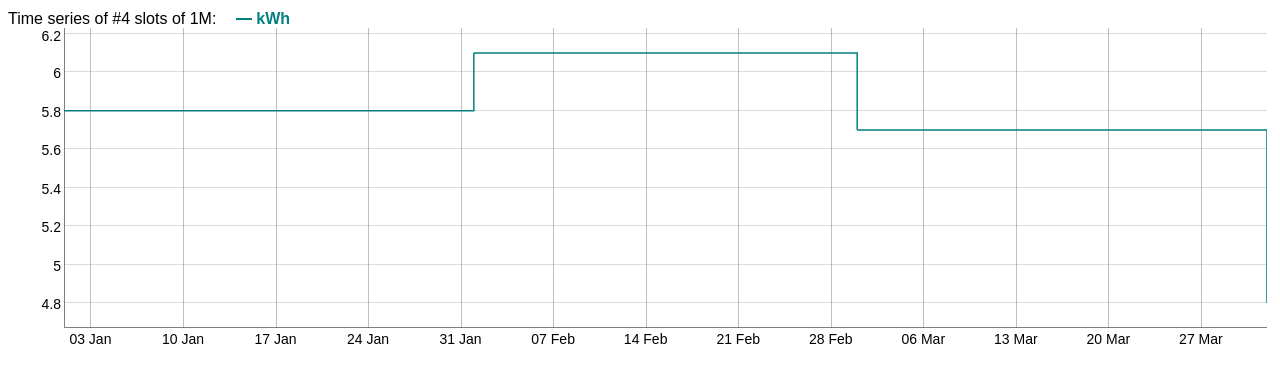

In [48]:
timeseries.plot()

As you can see the representation changes: from points connected with a linear interpolation we have a step plot, to get somehow closer to a histogram-style plot in order to graphycally render the concept of the slot (the missing line on the last slot is a plotting limitation that will be hopefully fixed in future). The example is indeed plotting an aggregated value for the months, which is the total energy consumprion in kWh.

The resolution of a slot series is simply the `TimeUnit` of the slots, and it is not defined (`None`) only for empty series.

In [49]:
timeseries.resolution

1M

To load and store data Timeseria uses the ***Storage*** objects. This can be anything capable of storing and loading data: a CSV file, a SQLite database, a Postgres database, or even a distributed NoSQL system. The idea is that you can wrap whatever load and store logic you want in a Storage object, thus decoupling the data storage step from the data processing. 

At the moment only CSV file storages are implemented in Timeseria, using  the ***CSVFileStorage*** class, and we will stick with this one here.

Let's load an indoor temperature time series from CSV file then:

In [50]:
from timeseria import storages, TEST_DATASETS_PATH
storage = storages.CSVFileStorage(TEST_DATASETS_PATH + 'temperature_winter.csv')
temperature_timeseries = storage.get()

In [51]:
temperature_timeseries

Time series of #14403 points at variable resolution (~10m), from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1555550400.0 (2019-04-18 01:20:00+00:00)

As in the example above, we can plot this time series as well, but in this case since there is too much data to provide a smooth plotting experience, data will be _aggregated_ before getting plotted, and the plot itself will look different than the previous one:

[INFO] timeseria.plots: Aggregating by "10" for improved plotting


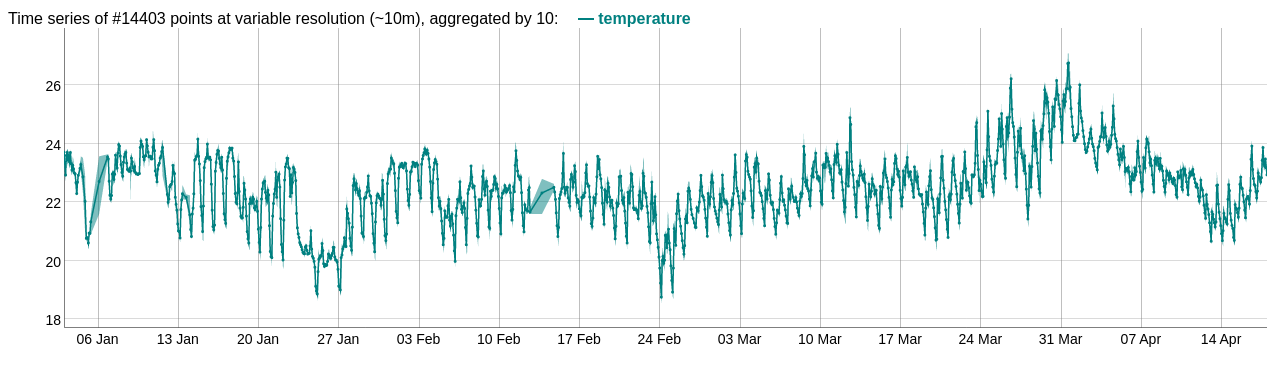

In [52]:
temperature_timeseries.plot()

In this plot, data has been aggregated by a factor of 10, and represented as a line chart plus an area chart (for the minimum and maximum values). In this way you can plot even millions of data points wihtout slowing down the plot engine or crashing your browser, without loosing much information about peaks and spikes.

If you want to see all the data, you can disable the aggregation, if you browser or the plotting engine does not crash (and it should not with this time series):

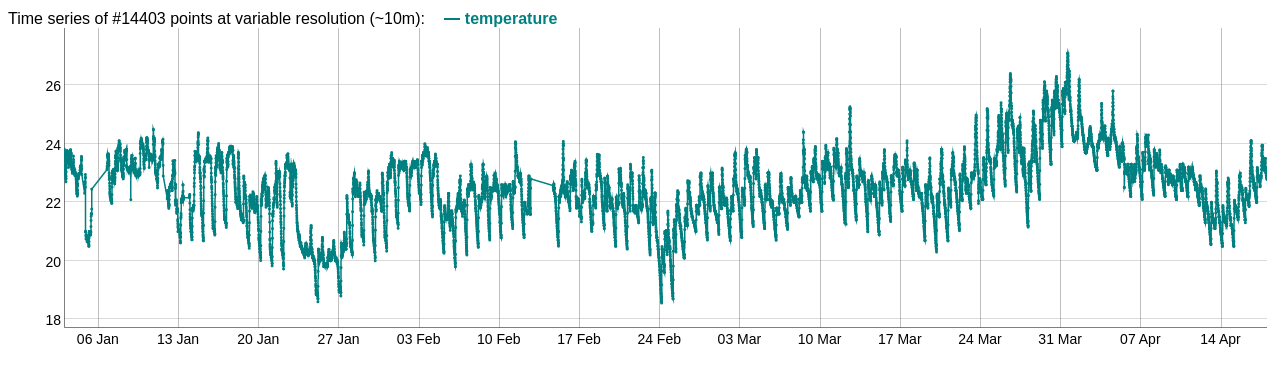

In [53]:
temperature_timeseries.plot(aggregate=False)


### Pandas DataFrames <a class="anchor" id="pands"></a>
***

Lastly, you can convert a time series as a Pandas DataFrame using the *to_df()* method (Slots are dumped using the starting point timestamp):

In [54]:
timeseries.to_df().head()

,kWh
Timestamp,
2016-01-01 00:00:00+00:00,5.8
2016-02-01 00:00:00+00:00,6.1
2016-03-01 00:00:00+00:00,5.7
2016-04-01 00:00:00+00:00,4.8


...and you can convert a Pandas data frame to a Timeseria time series as well:

In [55]:
TimeSeries.from_df(timeseries.to_df())

[INFO] timeseria.datastructures: Assuming slots with a slot time unit of "1M"


Time series of #4 slots of 1M, from slot starting @ 1451606400.0 (2016-01-01 00:00:00+00:00) to slot starting @ 1459468800.0 (2016-04-01 00:00:00+00:00)


# Transformations <a class="anchor" id="transformations"></a>

## Resampling <a class="anchor" id="resampler"></a>
***

To change the sampling rate of a point time series you can use the ***Resampler***. A Resampler is initialized by setting the new sampling interval, either as a floating point number for seconds or as a time unit or its string representation (i.e. '10s', '1m', '1h', etc.). They can be accessed from the transformations module (i.e. `from timeseria.transformations import Resampler`) or called directly from a time series, as it is done below. Resamplers do not support calendar time units as years, months, weeks and days.

In [56]:
resampled_temperature_timeseries = temperature_timeseries.resample(3600)

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 14403 DataTimePoints in 2519 DataTimePoints


Let's now plot the resampled time series:

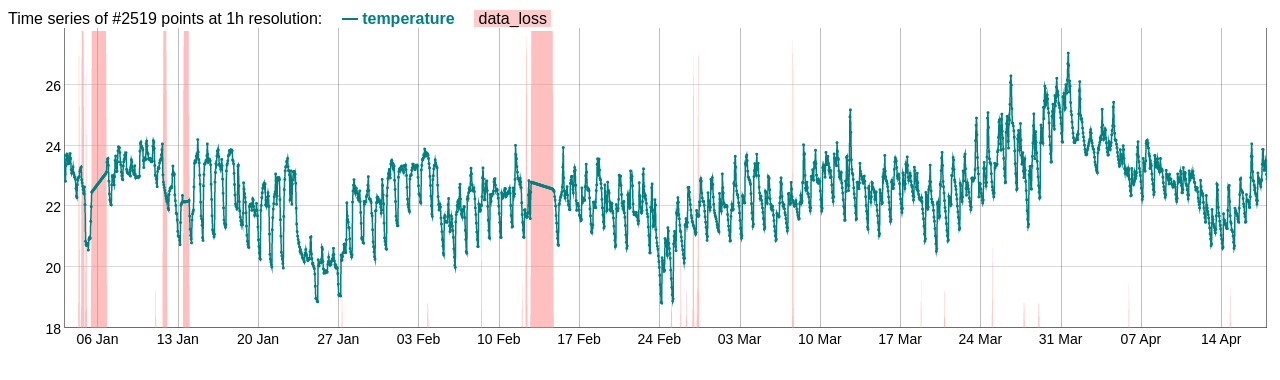

In [57]:
resampled_temperature_timeseries.plot() #data_indexes=['data_loss']

The most noticable thing here is the red highlight which is for data losses. A data loss occur when there is not enough information to create the new sample, either because there are not enough datapoints (data loss > 0 and < 1) or because there are no datapoins at all (data loss = 1). By default the resampler reconstructs completely missing data (data loss = 1) by linear interpolation.

You can of course just use a resampler to resample data with the same original sample rate as the original, in this case it will make data uniform and mark the data losses. Let's get back to the original temperature time series and let's have a look at the *resolution* attribute:

In [58]:
temperature_timeseries.resolution

'variable'

The sample rate is reported variable because even if the temperature time series is supposed to be sampled at a 600 seconds intervals, there are missing datapoints which make the sampling as, indeed, variable. Let's now resample it at the same 600 seconds:

In [59]:
uniformed_temperature_timeseries = temperature_timeseries.resample(600)

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Resampled 14403 DataTimePoints in 15121 DataTimePoints


...and let's have a look again at the resolution:

In [60]:
uniformed_temperature_timeseries.resolution

10m

Which is not variable anymore, but fixed at 600 seconds (and thus ready to be processed from a model, by the way).

## Aggregations <a class="anchor" id="slotter"></a>
***

To aggregate points in slots, you can use an ***Aggregator***. Similarly to the Resampler, an Aggregator is initialized by setting the target slot unit, either as a floating point number for seconds or as a time unit (including its string representation, i.e. '15m', '1D', '1M' etc.). Aggregations provide full support for calendar time units as years, months, weeks and days and the aggregation process correctly takes into account all the time math, properly handling timezones and DST changes. Aggegators can be accessed from the transformations module (i.e. `from timeseria.transformations import Resampler`) or called directly from a time series, as below:

In [61]:
hourly_temperature_timeseries = temperature_timeseries.aggregate('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Aggregated 14403 points in 2520 slots


As you can see, the aggregator automatically detected the sampling interval of the points in the input time series (10 minutes in this case, as we seen before). While this auto detection is usually fast and robust, you can also set the sampling rate manually, and there is also (limited) support for variable sampling rates defined on a per-point basis.

After detecting the sampling interval, the aggregation process is started and the hourly-slotted time series we asked for is created. The default aggregation operation is the *average*, but it can be easily changed (i.e. you might want to sum the data insetad of averaging it) and there is also support for extra operations as the min, max, etc. as well as for custom operations (see the <a href="#operations">operations</a> section for more details).

Let's have a look at the slotted time series then:

In [62]:
hourly_temperature_timeseries

Time series of #2520 slots of 1h, from slot starting @ 1546477200.0 (2019-01-03 01:00:00+00:00) to slot starting @ 1555545600.0 (2019-04-18 00:00:00+00:00)

In [63]:
hourly_temperature_timeseries.resolution

1h

...and now let's plot it:

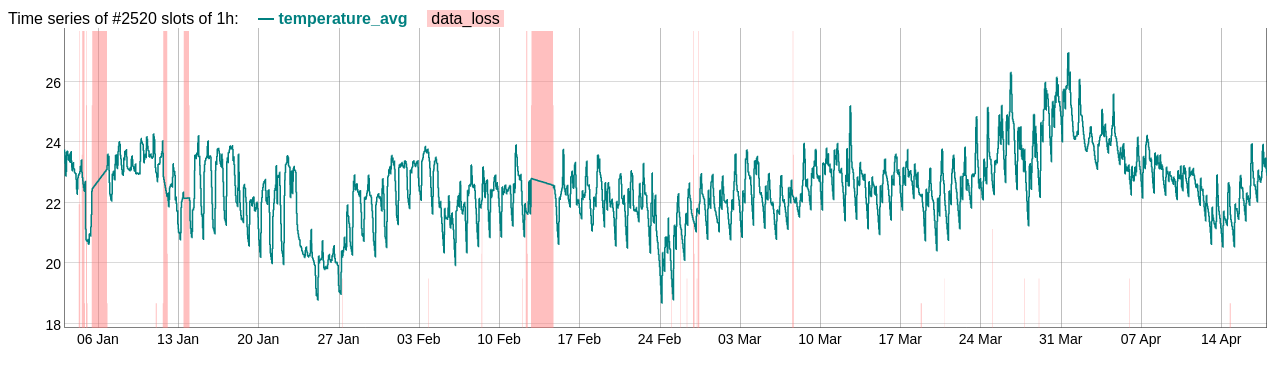

In [64]:
hourly_temperature_timeseries.plot()

<br/>
Another example, aggregating into one-day slots:

In [65]:
daily_temperature_timeseries = temperature_timeseries.aggregate('1D')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Aggregated 14403 points in 104 slots


In [66]:
daily_temperature_timeseries

Time series of #104 slots of 1D, from slot starting @ 1546560000.0 (2019-01-04 00:00:00+00:00) to slot starting @ 1555459200.0 (2019-04-17 00:00:00+00:00)

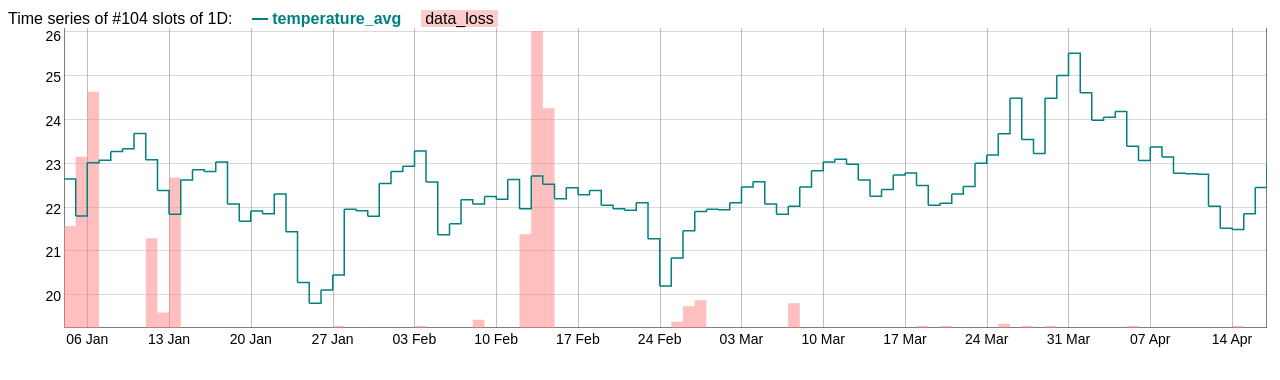

In [67]:
daily_temperature_timeseries.plot()

In [68]:
hourly_temperature_timeseries.resolution

1h

As final comment, please note that if you already have aggregated data, as hourly website visitors or daily energy consumptions, then you need to instantiate a time seris with **DataTimeSlots**. The **CSVFileStorage** has support for that, just set ***slots=True*** when calling the **get()** function.


# Operations <a class="anchor" id="operations"></a>
***

There are a number of operations available for manipulating time series, which are both available in the `operations` package as well as directly form the time series objects. Some of them return scalars:

In [69]:
hourly_temperature_timeseries.avg()

{'temperature_avg': 22.49468617724862}

In [70]:
hourly_temperature_timeseries.min()

{'temperature_avg': 18.692500000000006}

While others, as the differencing (`diff`), moving averages (`mavg`) and cumulative sum (`csum`) return instead other time series:

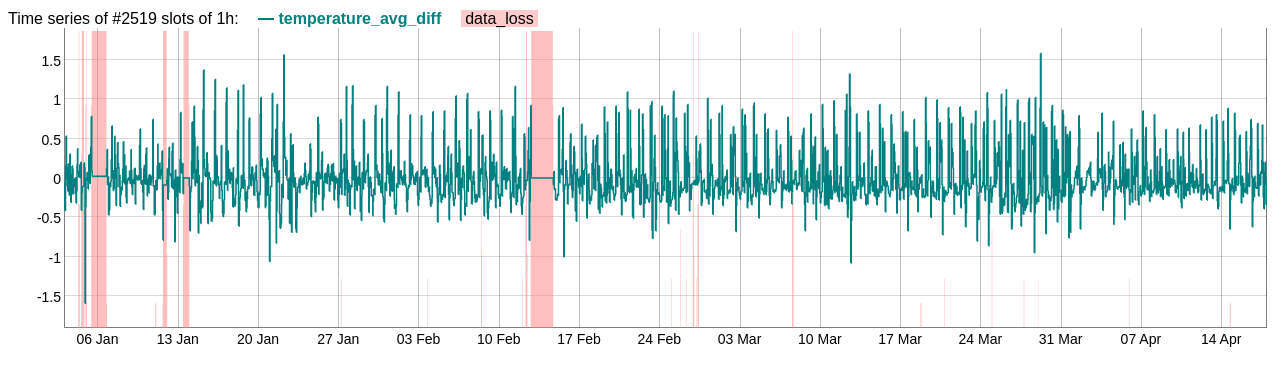

In [71]:
hourly_temperature_timeseries.diff().plot()

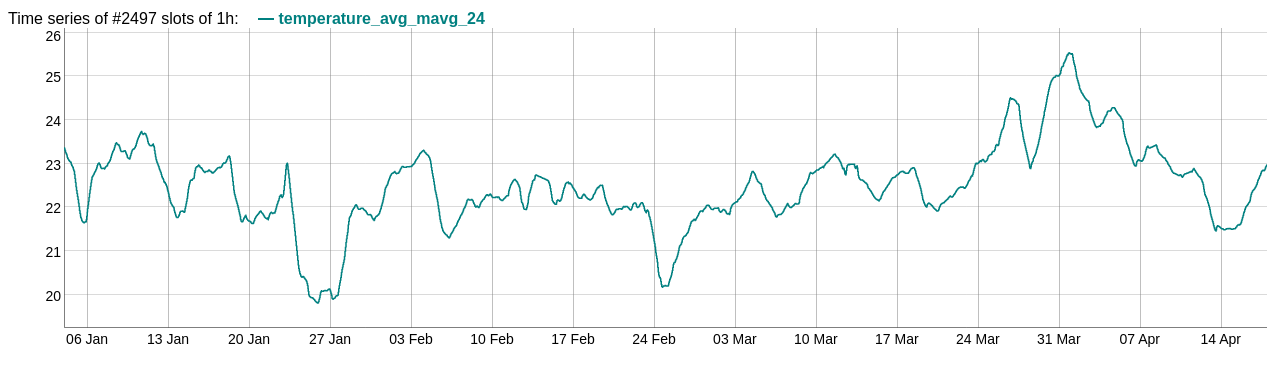

In [72]:
hourly_temperature_timeseries.mavg(24).plot()


Scalar operations can also be used when aggregating the time seris to perform custom aggregations, either by explicitly importing them (i.e. `from timeseria.operations import min, max, avg`) or by just setting their string representation:

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Aggregated 14403 points in 104 slots


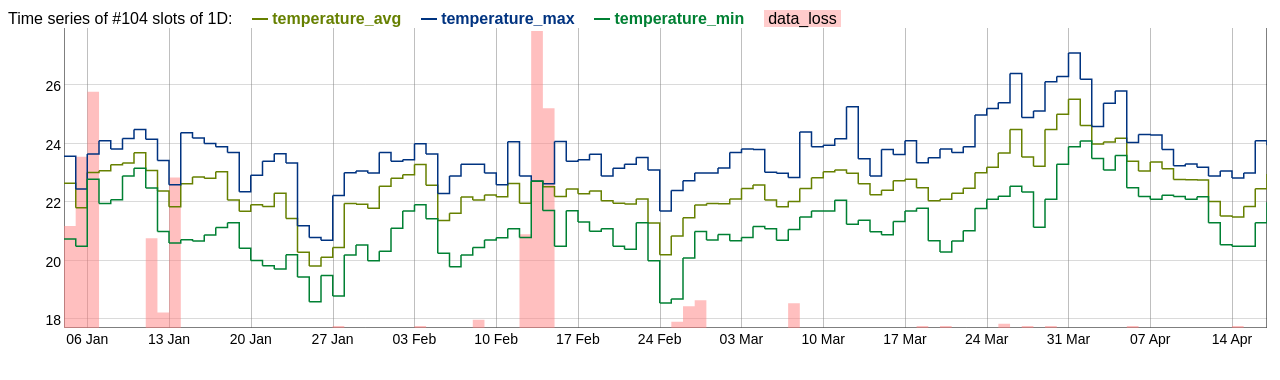

In [73]:
temperature_timeseries.aggregate('1D', operations=['avg', 'min', 'max']).plot()

<br/>
You can also define custom operations as simple Python functions, and use them within the slotting process:

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Aggregated 14403 points in 104 slots


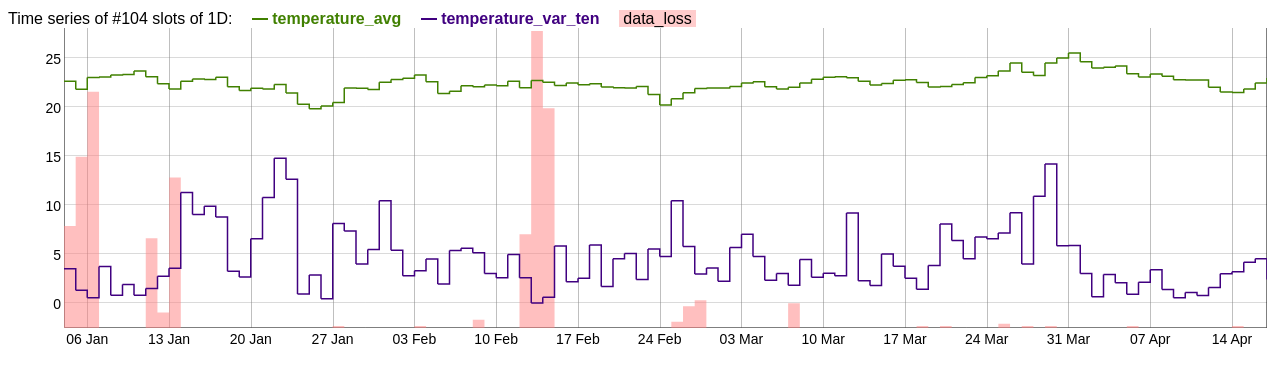

In [74]:
from statistics import variance, StatisticsError

def var_ten(timeseries_slice):
    '''When used in the Aggregator, this function is called for each slot, and its
    "timeseries_slice" argument is the time series portion relative to the slot
    being processed. This operation just computes the variance, times ten.'''
    variances = {}
    for label in timeseries_slice.data_labels():
        try:
            variances[label] = variance(point.data[label] for point in timeseries_slice)*10
        except StatisticsError:
            variances[label] = 0            
    return variances

var_ten_temperature_timeseries = temperature_timeseries.aggregate('1D', operations=['avg', var_ten])
var_ten_temperature_timeseries.plot()

<br />
There are also time series manipulation operations, as the merge, slice and filter:

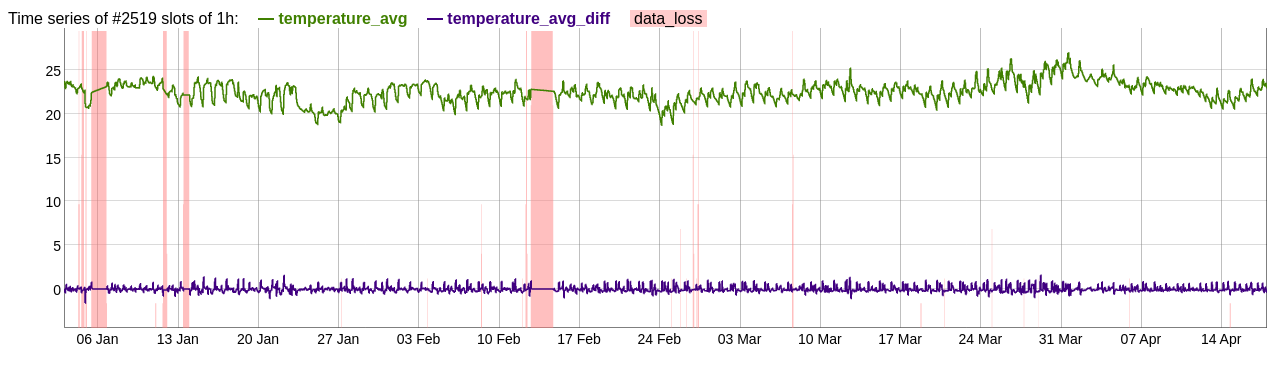

In [75]:
hourly_temperature_timeseries.merge(hourly_temperature_timeseries.diff()).plot()

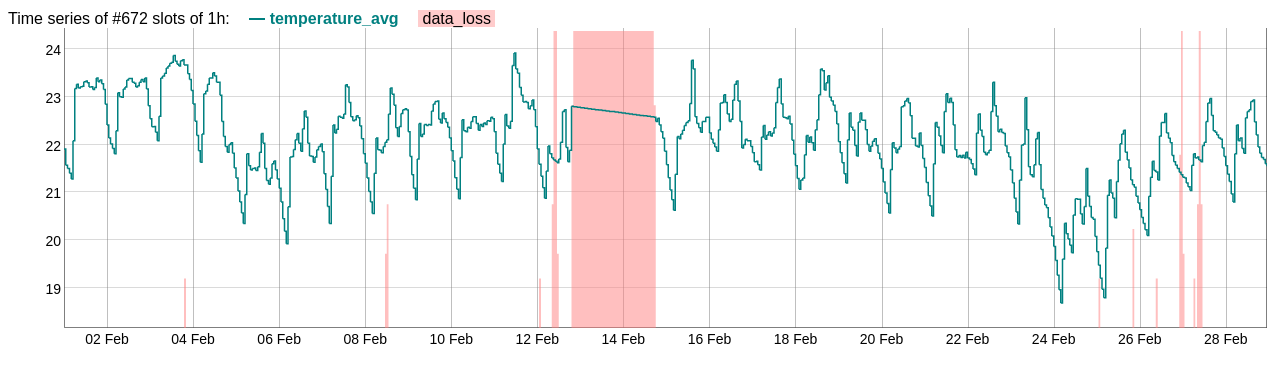

In [76]:
hourly_temperature_timeseries.slice(start=dt(2019, 2, 1), end=dt(2019,3,1)).plot()

The filter operation let you filter bthe time series by one or more data label(s):

In [77]:
var_ten_temperature_timeseries.filter('temperature_var_ten')

Time series of #104 slots of 1D, from slot starting @ 1546560000.0 (2019-01-04 00:00:00+00:00) to slot starting @ 1555459200.0 (2019-04-17 00:00:00+00:00)

...and if you just need to filter by a data label you can also use the square braket notation directly from the time series:

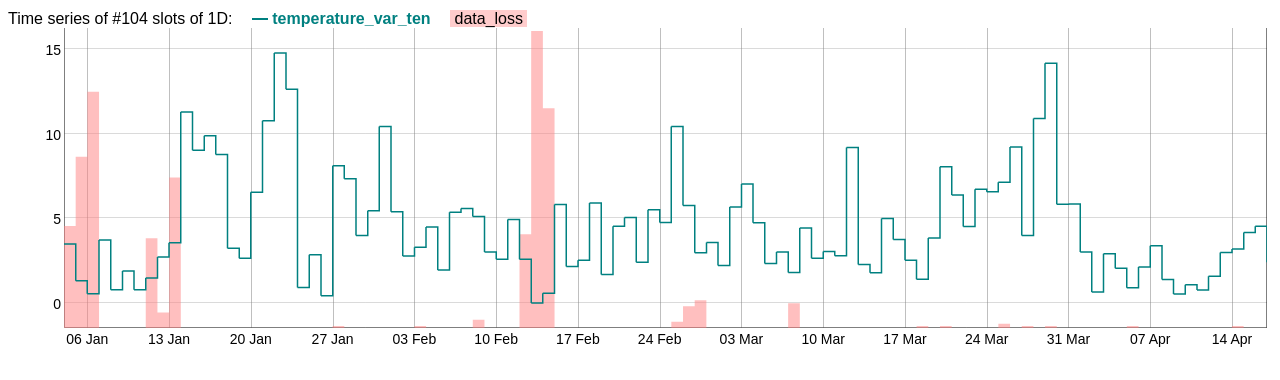

In [78]:
var_ten_temperature_timeseries['temperature_var_ten'].plot()


# Models <a class="anchor" id="models"></a>


There are two main models in Timeseria: the ***Models*** and the ***ParametricModels***. The first one are stateless (you can just use them as they are), while the second ones can be fitted, saved and loaded.



## Reconstructors <a class="anchor" id="reconstructors"></a>
***

Reconstructors are models that reconstruct missing parts of a time series *in the past*. By "in the past" it means that they expect to fill a gap in more or less sophisticated ways, but it is a gap where you know where you need to get after the gap starts: it is not a forecast.

Let's see how we can use one of the most simple data reconstruction models, the ***PeriodicAverageReconstructor***, that just detects if there is a periodicity in the time series and then creates an average for each slot of the period:

In [79]:
from timeseria.models import PeriodicAverageReconstructor
reconstructor = PeriodicAverageReconstructor()
reconstructor.fit(hourly_temperature_timeseries)

[INFO] timeseria.models.reconstructors: Detected periodicity: 24x 1h


The fit executed above detected for the temperature time series a periodicty of 24h hours, as one would expect.

Let's now apply the model on our original time series to get a time series where data is reconstructed if missing, and let's also have a look at how this reconstructed data looks like:

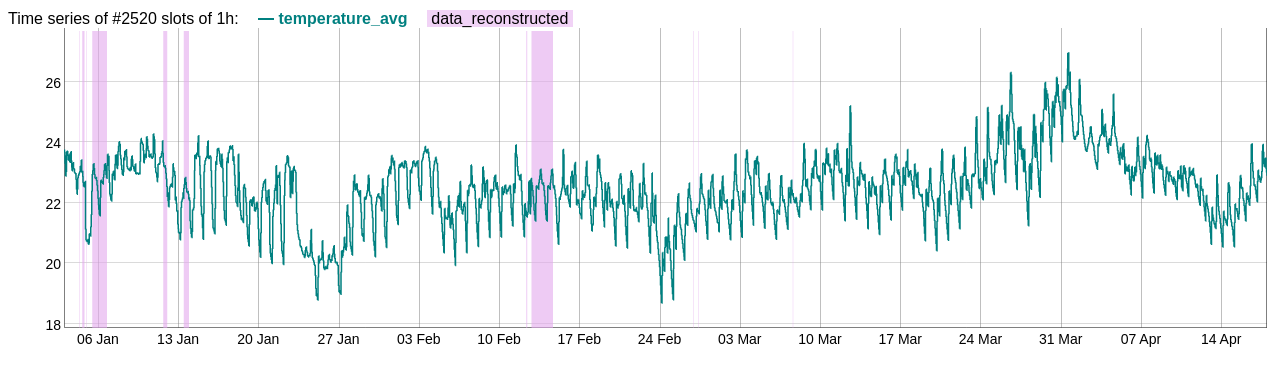

In [80]:
hourly_temperature_timeseries_reconstructed = reconstructor.apply(hourly_temperature_timeseries)
hourly_temperature_timeseries_reconstructed.plot(data_indexes=['data_reconstructed'])

Having a data reconstruction algorithm in place does not mean that using its data is always what you want to do: for each slot you always have the **data_loss** index, so that you can choose the logic you prefer when using them for your statistics or for training your models, and you can for example decide that you don't want to include any slot with data_loss above a given threshold.

You can also use the extra **data_loss_threshold** parameter when applying a data reconstruction model to set when it should kick in (or, in other words, when you consider the original data still representative for the slot, even if some of it was missing). This parameter is by default set to one, which means to reconstruct only slots where there was no data at all.

Reconstructors, and all the other models in the follwoing, can make use of far more advanced time series modeling techniques based on ARIMA, [Facebook's Prophet](https://facebook.github.io/prophet/), LSTM neural netowrs, and more.


## Forecasters <a class="anchor" id="forecasters"></a>
***

Timeseria uses ***Forecaster*** models to perform forecasts, as the ***PeriodicAverageForecaster***, which like the **PeriodicAverageReconstructor** detects if there is a periodicty in the time series and then create an average for each time slot of the period, which is then used to forecast one or more data points in the future based on a window of past data points which is by default set equal to the periodicty.

In [81]:
from timeseria.models import PeriodicAverageForecaster
forecaster = PeriodicAverageForecaster()
forecaster.fit(hourly_temperature_timeseries_reconstructed)

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"


Let's now forecast three days:

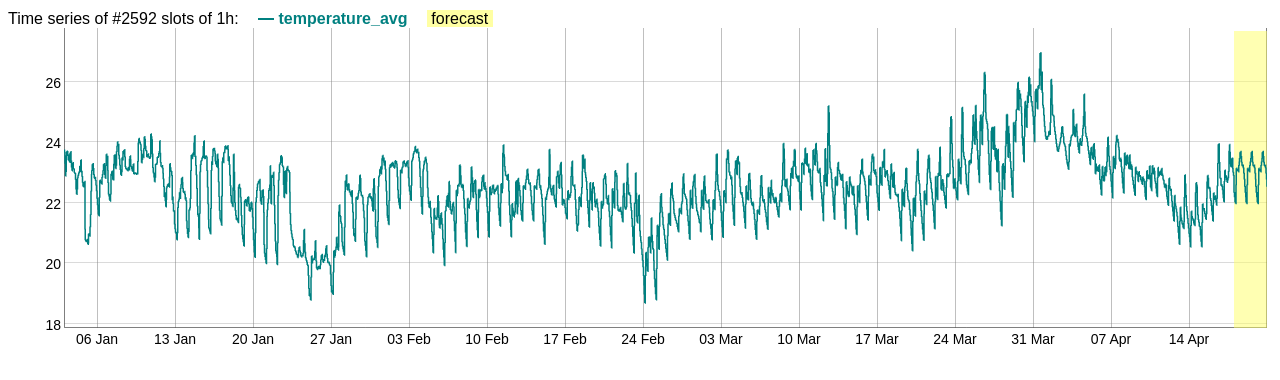

In [82]:
hourly_temperature_timeseries_forecast = forecaster.apply(hourly_temperature_timeseries_reconstructed, steps=24*3)
hourly_temperature_timeseries_forecast.plot(data_indexes=['forecast'])

While this forecast seems quite reasonable, please keep in mind that this model is really simple and that this data (although real data) is particularly well suited for this use-case.

## Anomaly Detectors <a class="anchor" id="anomaly"></a>
***

Anomaly detectors detect if something is not following a definition of "normal". For example, the ***PeriodicAverageAnomalyDetector*** works by fitting a **PeriodicAverageForecaster** model and then evaluating for each point the error between the forecast and the real value, computing an anomalay index.

In [83]:
from timeseria.models import PeriodicAverageAnomalyDetector
anomaly_detector = PeriodicAverageAnomalyDetector()
anomaly_detector.fit(hourly_temperature_timeseries)

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.anomaly_detectors: Predictive model(s) fitted, now evaluating...
[INFO] timeseria.models.anomaly_detectors: Computing actual vs predicted for "temperature_avg"...
[INFO] timeseria.models.anomaly_detectors: Model(s) evaluated, now computing the error distribution(s)...
[WARNING] timeseria.models.anomaly_detectors: The error distribution for "temperature_avg" is not centered in (almost) zero, but in 0.01641004948027594. Expect issues.
[INFO] timeseria.models.anomaly_detectors: Anomaly detector fitted


In [84]:
hourly_temperature_timeseries_anomalies = anomaly_detector.apply(hourly_temperature_timeseries_reconstructed)

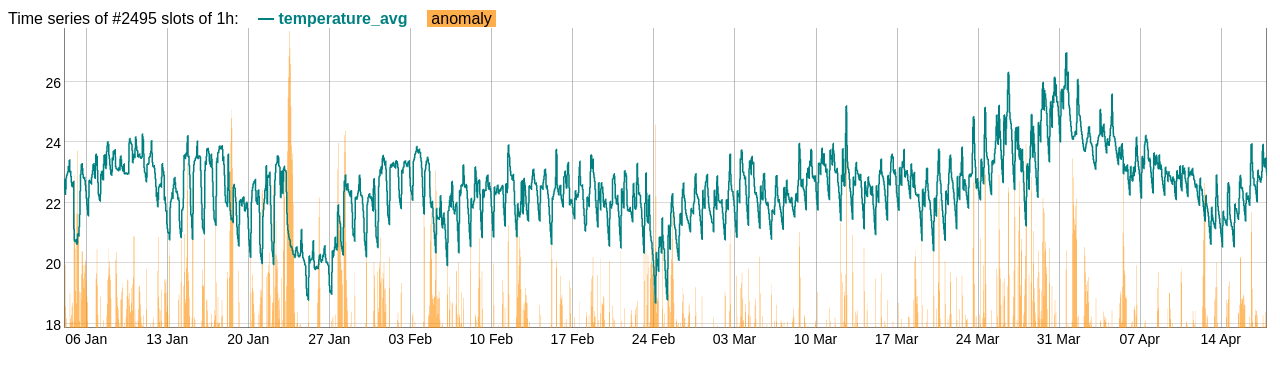

In [85]:
hourly_temperature_timeseries_anomalies.plot(data_indexes=['anomaly'])

As you can see the bigger anomaly is detected 23 january 2019 afternoon, where instead of the usual rising peak the temperature was instead falling steady.

## Custom models <a class="anchor" id="custom"></a>
***

To implement your own custom models for time series, you just need to extend one of the three main base classes (**SeriesReconstructor**, **SeriesForecaster**, **SeriesAnomalyDetector**) and to implement the `_fit()` and `_predict()` methods.

Here is an example for a forecaster using an "averaged hold" strategy, which will compute the prediction by avearging the last value of the time series with its average over the time series itself:

In [86]:
from timeseria.models import Forecaster

class MyForecaster(Forecaster):

    @Forecaster.fit_function
    def fit(self, series):

        # Compute the average value on the time series for each data label, but skip when the
        # data loss is 100%, to prevent fitting the model on data which is not reliable.
        averages = {}
        valid_datapoints = 0
        for item in series:            
            if item.data_loss == 1:
                continue
            valid_datapoints+=1
            for label in series.data_labels():
                if label not in averages:
                    averages[label] = item.data[label]
                else:
                    averages[label] += item.data[label]
        self.averages = {label:averages[label]/valid_datapoints for label in series.data_labels()}

    @Forecaster.predict_function
    def predict(self, series, steps=1):

        # Disable the forecast for steps>1. Note that Timeseria will still be able to run multi-step
        # ahead forecasts as it will just append a prediction ad use it as if it was a real value.
        if steps > 1:
            raise NotImplementedError('Cannot forecast in one-go for steps>1')

        # Compute the prediction for each data label by avearging the last value with its average
        # over the time series, computed in the _fit().   
        prediction = {}
        for label in series.data_labels():
            prediction[label] = (series[-1].data[label] + self.averages[label]) / 2

        return prediction


The model can now be used exactly as the other ones, with all the common  functionalities coming for free:

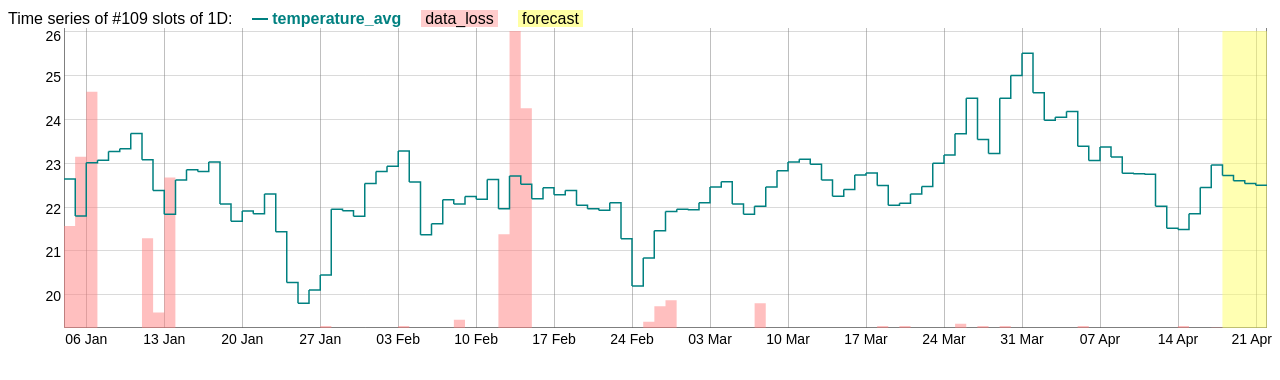

In [87]:
my_forecaster = MyForecaster()
my_forecaster.fit(daily_temperature_timeseries)
daily_temperature_timeseries_forecast = my_forecaster.apply(daily_temperature_timeseries, steps=5)
daily_temperature_timeseries_forecast.plot()


## Model Evaluation <a class="anchor" id="evaluation"></a>
***
For the sake of exposition a lot of details about model accuracy, error metrics, reliability, generalization and so on were omitted, but one of the main features of Timeseria is actually to make it easy to perform also this kind of tasks.

Let's get back to our forecaster and evaluate it in the same time series using for the fit, which will give you an idea about how good the model is to capture the dynamic (but will tell you nothing about how the model will perform on date it has never seen):

In [88]:
forecaster.evaluate(hourly_temperature_timeseries)

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE': 0.6169380353760734, 'MAE': 0.4623358123695572}

By default, the evaluation is done on the first 1000 samples, but this choice is just to speed up the default evaluation behaviour. If you want to evaluate on all the samples:

In [89]:
forecaster.evaluate(hourly_temperature_timeseries, limit=None)

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE': 0.6169380353760734, 'MAE': 0.4623358123695572}

To get a better sense of how the model would actually work on data that it has never seen, you have to train and evaluate on specific subsets of the same time series, also known as trainig and test data.

While you can prepare the training and test data by slicing a time series (either by index or by datetime), but you can also just pass the boundaries to the fit() and evaluate() methods, which would avoid duplicating data to create the test and training sets.

Let's fit a forecaster until the first of March then:

In [90]:
from propertime.utils import dt
forecaster = PeriodicAverageForecaster()
forecaster.fit(hourly_temperature_timeseries, end=dt(2019,3,1))

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"


..and let's evalate it from the first of March until the end:

In [91]:
forecaster.evaluate(hourly_temperature_timeseries, start=dt(2019,3,1), limit=None)

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE': 0.558216668469224, 'MAE': 0.422312410606239}

As you might have noticed, the evaluation is done foe one step ahead and 24 steps ahead, which is the periodicity of this temperature signal. But you can evaluate on specific steps if you care more about them, for example about the evolotion of the temperature over the next three hours:

In [92]:
forecaster.evaluate(hourly_temperature_timeseries, start=dt(2019,3,1), steps=[1,2,3])

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 2, 3] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE': 0.4887083276770387, 'MAE': 0.3654376482671273}

Which is more reliable than a 24-steps ahead prediction, as one would expect. You can also include the details and set which error metrics (at the moment only RMSE, MAE and MAPE are supported:

In [93]:
forecaster.evaluate(hourly_temperature_timeseries, start=dt(2019,3,1), details=True, metrics=['MAE', 'MAPE'])

[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['MAE', 'MAPE']


{'MAE_1_steps': 0.35841933529113856,
 'MAPE_1_steps': 0.015491234322162937,
 'MAE_24_steps': 0.4862054859213394,
 'MAPE_24_steps': 0.021023151295268036,
 'MAE': 0.422312410606239,
 'MAPE': 0.018257192808715485}

You can also run cross validation:

In [94]:
forecaster = PeriodicAverageForecaster()
forecaster.cross_validate(hourly_temperature_timeseries, rounds=3)

[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']
[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']
[INFO] timeseria.models.forecasters: Detected periodicity: 24x 1h
[INFO] timeseria.models.forecasters: Using a window of "24"
[INFO] timeseria.models.forecasters: Will evaluate model for [1, 24] steps ahead with metrics ['RMSE', 'MAE']


{'RMSE_avg': 0.6254694839997564,
 'RMSE_stdev': 0.12823943311774644,
 'MAE_avg': 0.4780063869043883,
 'MAE_stdev': 0.09841900960591267}


# Timezones and their implications <a class="anchor" id="timezones"></a>
***
Until now we did not mention anything about timezones. Timeseria silently assumed everything on UTC, since in Timeseria there are no timestamps without a timezone (and epoch seconds are on UTC by definition).

However, in time series data analysis, timezones often steps in, and in particular due to Daylight Saving Time (DST), also known as summertime.

Timeseria tries to provide extensive support for timezones, so that the slotter will for example correclty compute the slots. Let's change the timezone of the temperature time series and re-slot it in days:

In [95]:
temperature_timeseries_Rome = temperature_timeseries.as_tz('Europe/Rome')

So this thime series is now on timezone Europe/Rome, and the offset of its data with respect to UTC is +1 hour at the beginning and +2 hours at the end, because it includes a DST change.

let's now aggregate the time series into one-day slots:

In [96]:
daily_temperature_timeseries_Rome = temperature_timeseries_Rome.aggregate('1D')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 600.0s
[INFO] timeseria.transformations: Aggregated 14403 points in 104 slots


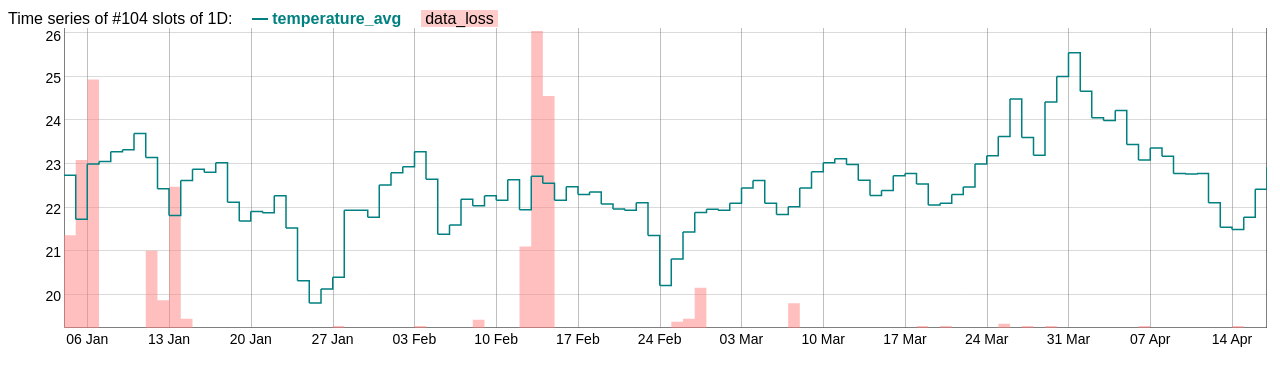

In [97]:
daily_temperature_timeseries_Rome.plot()

The plot is reporting the Europe/Rome timezone, but most importantly the slots have been computed on the data actually belonging to days on the Europe/Rome timezone and the slot value is averaged on the correct duration of the day, that when the DST change it is not 86400 seconds:

In [98]:
for slot in daily_temperature_timeseries_Rome.slice(start = dt(2019,3,30, tz='Europe/Rome'),
                                                    end   = dt(2019,4,2,  tz='Europe/Rome')):
    print('Slot starting at {} --> lenght {}'.format(slot.start.dt,slot.length))

Slot starting at 2019-03-30 00:00:00+01:00 --> lenght 86400.0
Slot starting at 2019-03-31 00:00:00+01:00 --> lenght 82800.0
Slot starting at 2019-04-01 00:00:00+02:00 --> lenght 86400.0




To get a better sense about how timezones and DST can impact time series modeling, let's consider the following example, which is traffic data from an Highway situated north to London by [Highways England](https://data.gov.uk/dataset/9562c512-4a0b-45ee-b6ad-afc0f99b841f/highways-england-network-journey-time-and-traffic-flow-data):

[INFO] timeseria.storages: Assuming 15m time unit and creating Slots.


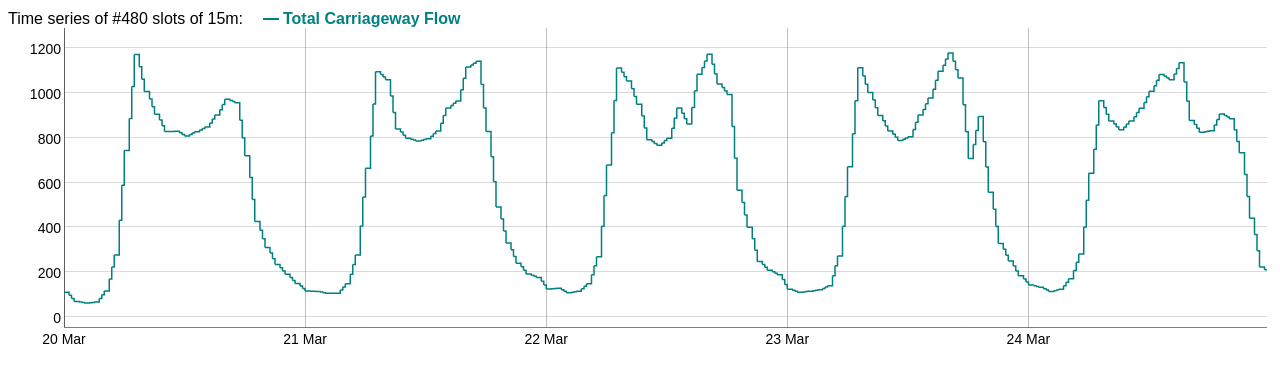

In [99]:
traffic_timeseries1 = storages.CSVFileStorage(TEST_DATASETS_PATH + 'traffic1.csv', series_type='slots').get()
traffic_timeseries1.plot()

Here you can clearly see that the peaks of the morning commute at 7 AM.

Let's now load another portion of the data:

[INFO] timeseria.storages: Assuming 15m time unit and creating Slots.


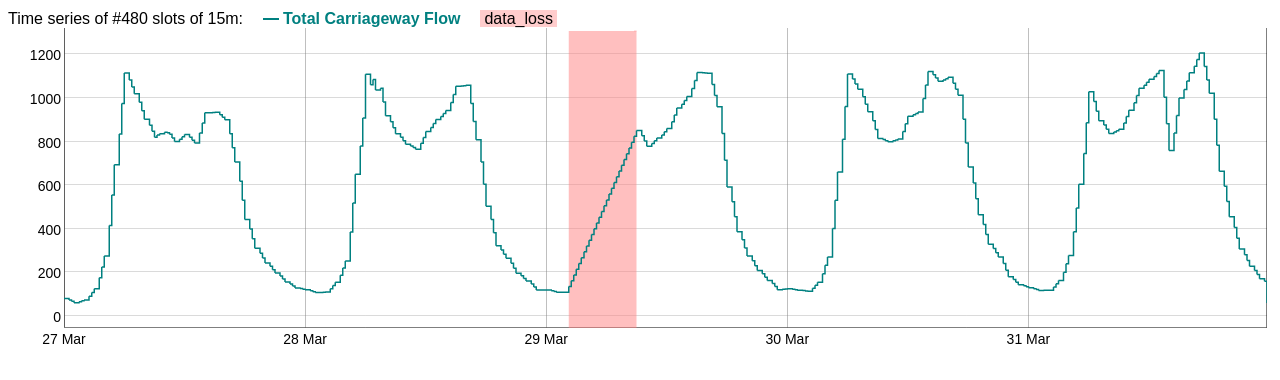

In [100]:
traffic_timeseries2 = storages.CSVFileStorage(TEST_DATASETS_PATH + 'traffic2_missing.csv', series_type='slots').get()
traffic_timeseries2.plot()

Here, apart from the missing data, you can see that the peak is not at 7 AM anymore, instead it is at 6 AM. This is because the DST changed in between the first and the second timeseries, thus shifiting everything by one hour. If you were trying to compute on these two time series, for example, hourly avergaes of highway traffic, you would have got to a misleading answer. 

Assuming everything on UTC and using epoch sounds indeed clean and simple at first, but clashes with real world data, that if not purely "physical" gets heavily affected by DST. At the same time, not useing UTC and epoch but local times makes time math much harder and completely breaks it twice a year (when DST goes off you go back in time of one hour, and when it kics in you jump in future of one hour, causing the 23-hour and 25-hour days already mentioned with regard to the Slots and the variable time units).

To adress these issues, Timeseria tries to keep both at the same time, meaning that you always have epoch (and you can do whatever time math you want) and local time (provided that you decorated the time series with a timezone), as showed above when slotting the timezone-aware temperature timeseries.

Let's decorate our timeseries with the London timezone then:

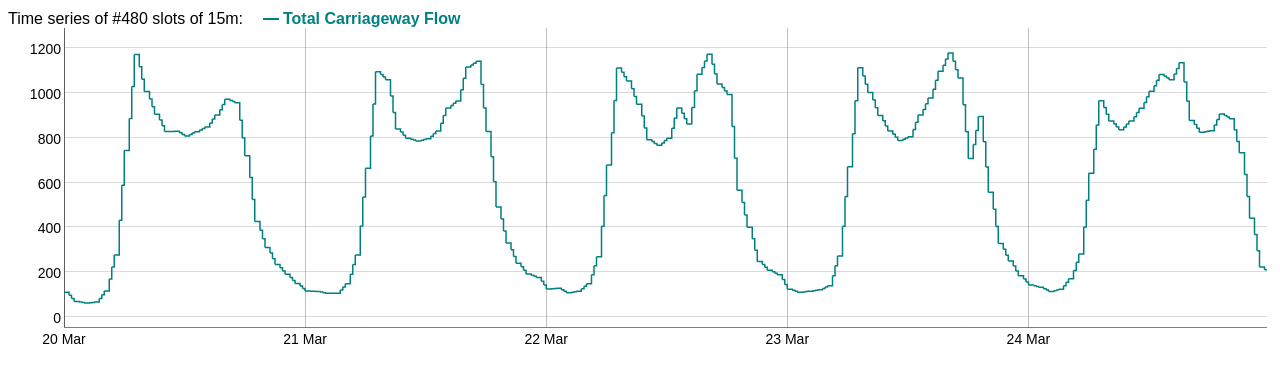

In [101]:
traffic_timeseries1.change_tz('Europe/London')
traffic_timeseries1.plot()

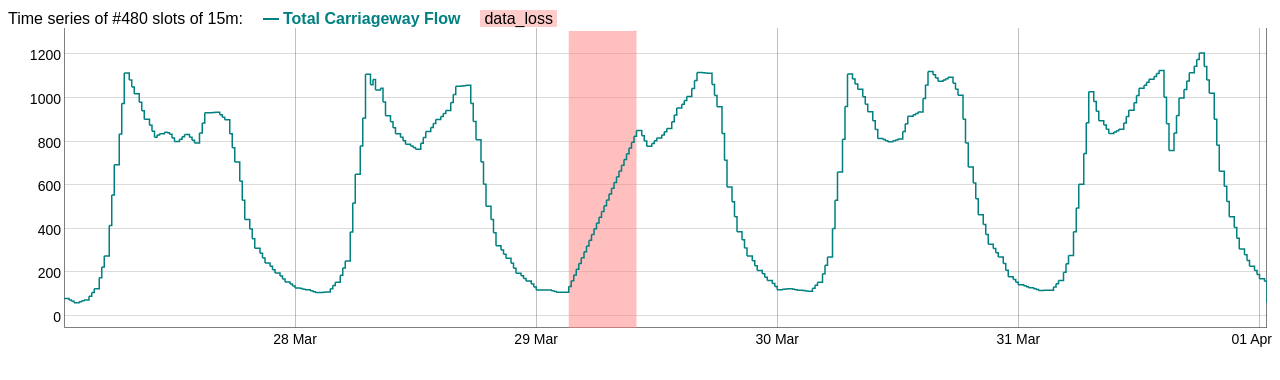

In [102]:
traffic_timeseries2.change_tz('Europe/London')
traffic_timeseries2.plot()

..so now you can clearly see that all the peaks are at 7 AM London time. If we now want to train a reconstructor without telling it that it has to be affected by DST, this is what we get:

[INFO] timeseria.models.reconstructors: Detected periodicity: 96x 15m


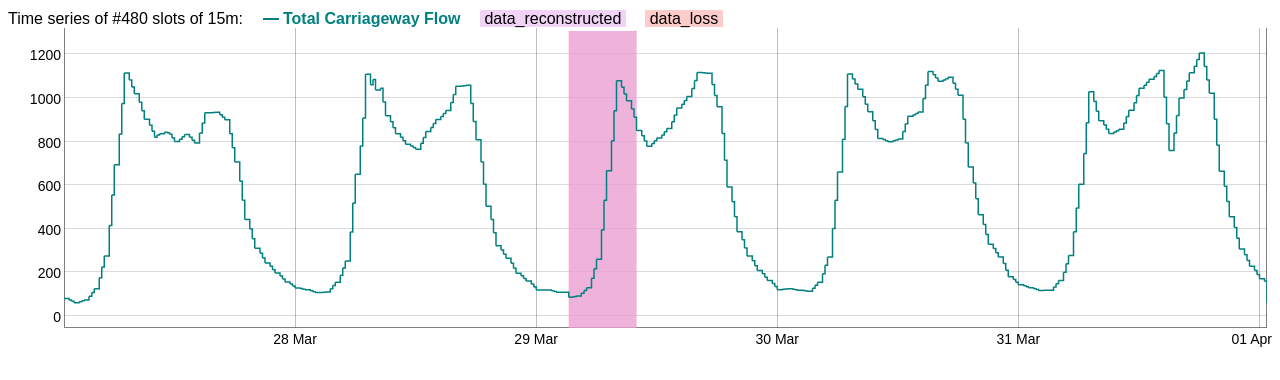

In [103]:
from timeseria.models import PeriodicAverageReconstructor
reconstructor = PeriodicAverageReconstructor()
reconstructor.fit(traffic_timeseries1)
r_traffic_timeseries2 = reconstructor.apply(traffic_timeseries2)
r_traffic_timeseries2.plot()

..or a wrong reconstruction (the peak is now at 8 AM London time due to the lack of DST-awareness. But if we tell the reconstructor to be DST-aware (which requires a timezone-aware tmeseries), then the reconstruction works correctly:

[INFO] timeseria.models.reconstructors: Detected periodicity: 96x 15m


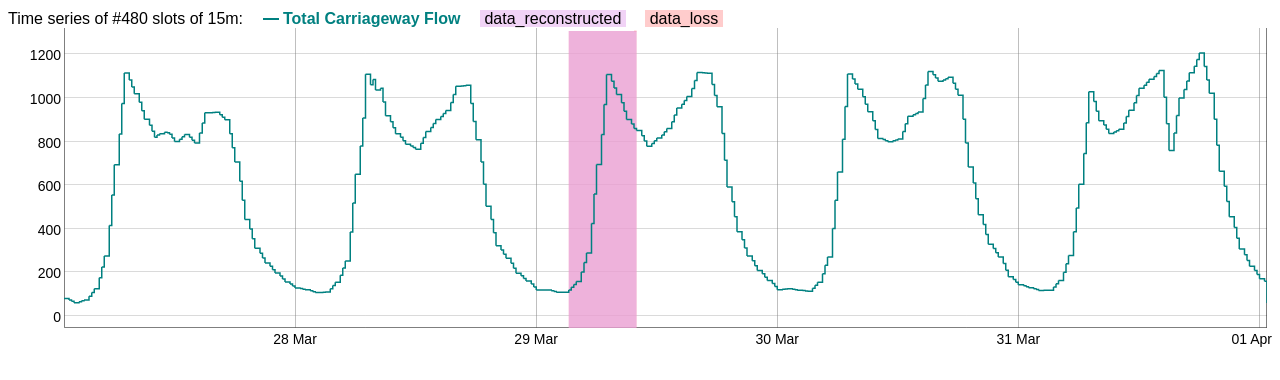

In [104]:
from timeseria.models import PeriodicAverageReconstructor
reconstructor = PeriodicAverageReconstructor()
reconstructor.fit(traffic_timeseries1, dst_affected=True)
r_traffic_timeseries2 = reconstructor.apply(traffic_timeseries2)
r_traffic_timeseries2.plot()

This is a trivial example, however there are phenomena which are affected by both natural and DST cycles, and Timeseria gives all the framework to corrctly handle timezones in order to having everything working correctly.

# Where to go from here <a class="anchor" id="where_to_go"></a>

You can have a look at the [quickstart notebook](https://github.com/sarusso/Timeseria-notebooks/blob/main/notebooks/Quickstart.ipynb), which gives a recap of the main functionalities available in Timeseria.


You can also try yourself by running the Timeseria Docker container, wich comes with this example notebooks repository pre-installed:

    docker run -it -p8888:8888 sarusso/timeseria


Or, you can give it a try in your own projects:

    pip install timeseria
    

..and you can of course contribute! :)